In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from skimage.transform import resize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32

img_transform = transform.Compose([transform.ToTensor(),transform.Resize([int(255),int(255)]),transform.Normalize((0.5,),(0.5,))]) 


cuda:0


In [2]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
folder_low="C:/Users/matia/Desktop/AI_UTEC/proyecto6/data_short/low"
arr_low=load_images(folder_low)
folder_high="C:/Users/matia/Desktop/AI_UTEC/proyecto6/data_short/high"
arr_high=load_images(folder_high)

In [4]:
def show_img(img):
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

In [5]:
def elim_extra_dim(arr):
    for i in range(len(arr)):
        if(len(arr[i][0][0])==4): arr[i]=np.delete(arr[i],3,2)

In [6]:
elim_extra_dim(arr_low)
elim_extra_dim(arr_high)

In [7]:
tuplas=[]
print(len(arr_low),len(arr_high))

for i in range(len(arr_low)):
    tuplas.append((img_transform(arr_low[i]),img_transform(arr_high[i])))

955 955


C:\Users\matia\anaconda3\lib\site-packages\torchvision\transforms\functional.py:126: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:189.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


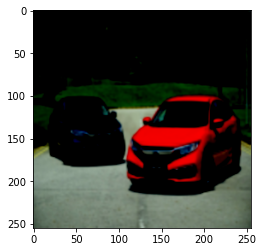

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


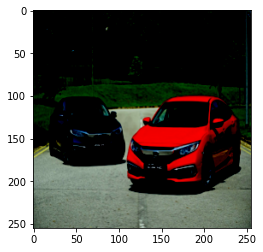

In [8]:
show_img(tuplas[0][0])
show_img(tuplas[0][1])

In [9]:
train_set,test_set=torch.utils.data.random_split(tuplas,[812,143], generator=torch.Generator().manual_seed(0))
val_set,test_set=torch.utils.data.random_split(test_set,[101,42], generator=torch.Generator().manual_seed(0))

img, _ = train_set[0]
print(img.shape)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

torch.Size([3, 255, 255])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


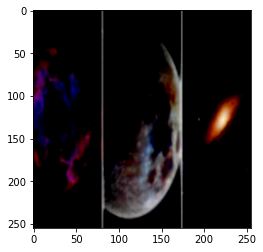

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


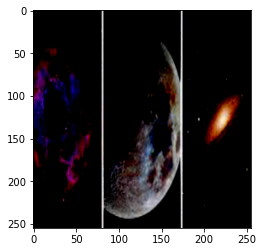

In [10]:
show_img(train_set[100][0])
show_img(train_set[100][1])
latent_dims = 200

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=1),
                                    nn.ReLU())
        self.layer2 = nn.Sequential( nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6, stride=2, padding=1),
                                    nn.ReLU())
        self.layer3 = nn.Sequential( nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
                                    nn.ReLU())
        self.layer4 = nn.Sequential( nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU())
        
        self.layerpool0 = nn.MaxPool2d(kernel_size=3, stride=2,return_indices=True)
        
        self.fc = nn.Linear(in_features=256*15*15, out_features=latent_dims)

    def forward(self, image):
        out = self.layer1(image)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out,indices = self.layerpool0(out)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        z = self.fc(out)
        return z,indices

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc        = nn.Linear(in_features=latent_dims,out_features=256*15*15)
        
        self.pool0      = nn.MaxUnpool2d(kernel_size=3, stride=2)
        
        self.convlayer0 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU())
        self.convlayer1 = nn.Sequential( nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
                                    nn.ReLU())
        self.convlayer2 = nn.Sequential( nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2, padding=1),
                                    nn.ReLU())
        self.convlayer3 = nn.Sequential( nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=7, stride=2, padding=1),
                                    nn.ReLU())
        
    def forward(self, latent,indices):
        out = self.fc(latent)
        out = out.view(out.size(0), 256, 15, 15)
        out = self.pool0(out,indices)
        out = self.convlayer0(out)
        out = self.convlayer1(out)
        out = self.convlayer2(out)
        out = self.convlayer3(out)
        return out

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent,indices = self.encoder(x)
        x_recon = self.decoder(latent,indices)
        return  x_recon

In [13]:
def train(model, train_loader, Epochs, loss_fn):
    
    train_loss_avg = []
    val_loss_avg = []
    test_loss_avg = []
    
    for epoch in range(Epochs):
        
        train_loss_avg.append(0)
        val_loss_avg.append(0)
        test_loss_avg.append(0)
        
        num_batches = 0
        num_batches_val = 0
        num_batches_test = 0

        
        
        for image_batch_prev, image_batch_desp  in train_loader:
            image_batch_prev = image_batch_prev.to(device)
            image_batch_desp = image_batch_desp.to(device)
            image_batch_recon = model(image_batch_prev)
            loss = loss_fn(image_batch_recon, image_batch_desp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_avg[-1] += loss.item()
            num_batches += 1

        for image_batch_prev, image_batch_desp  in test_loader:
            image_batch_prev = image_batch_prev.to(device)
            image_batch_desp = image_batch_desp.to(device)
            image_batch_recon = model(image_batch_prev)
            loss = loss_fn(image_batch_recon, image_batch_desp)
            test_loss_avg[-1] += loss.item()
            num_batches_test+=1
          
        for image_batch_prev, image_batch_desp  in val_loader:
            image_batch_prev = image_batch_prev.to(device)
            image_batch_desp = image_batch_desp.to(device)
            image_batch_recon = model(image_batch_prev)
            loss = loss_fn(image_batch_recon, image_batch_desp)
            val_loss_avg[-1] += loss.item()
            num_batches_val+=1
          
        print(epoch,end=" ")
    print()
    train_loss_avg[-1] /= num_batches
    test_loss_avg[-1] /= num_batches_test
    val_loss_avg[-1] /= num_batches_val
    print('Epoch [%d / %d] train average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    print('Epoch [%d / %d] test average reconstruction error: %f' % (epoch+1, Epochs, test_loss_avg[-1]))
    print('Epoch [%d / %d] val average reconstruction error: %f' % (epoch+1, Epochs, val_loss_avg[-1]))

    return train_loss_avg,test_loss_avg,val_loss_avg

In [14]:
capacity = 64
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()


loss_result_train,loss_result_test,loss_result_val = train(autoencoder,train_loader,40,loss)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
Epoch [35 / 35] average reconstruction error: 0.256925


In [15]:
def Show(out, title = ''):
    print(title)
    out = out.permute(1,0,2,3)
    grilla = torchvision.utils.make_grid(out,10,5)
    plt.imshow(transforms.ToPILImage()(grilla), 'jet')
    plt.show()

def Show_Weight(out):
    grilla = torchvision.utils.make_grid(out)
    plt.imshow(transform.ToPILImage()(grilla), 'jet')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 255, 255])


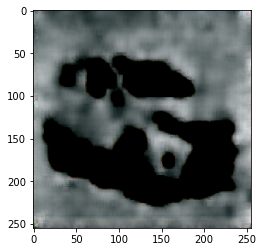

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


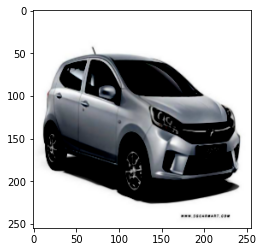

------------------------------------------------


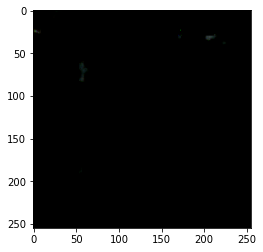

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


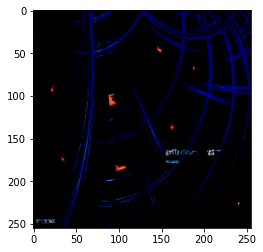

------------------------------------------------


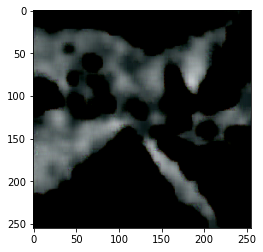

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


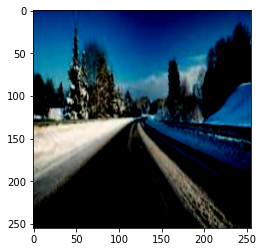

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------


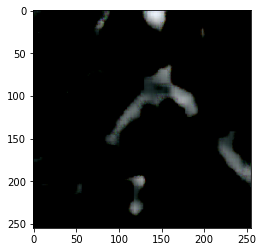

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


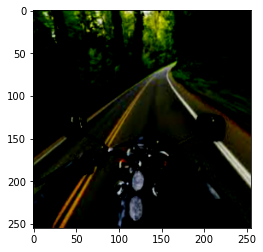

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------


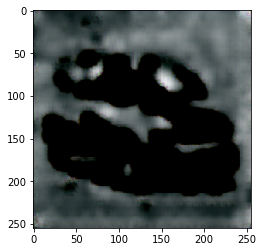

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


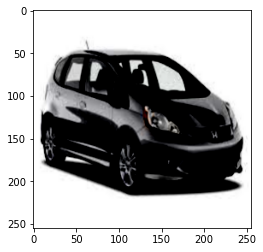

------------------------------------------------


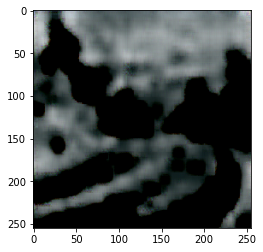

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


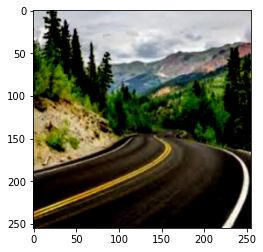

------------------------------------------------


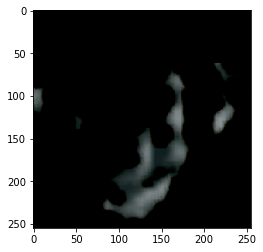

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


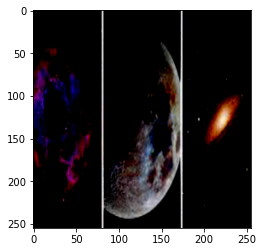

------------------------------------------------


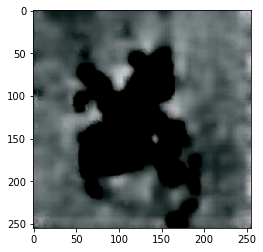

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


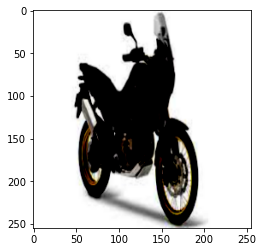

------------------------------------------------


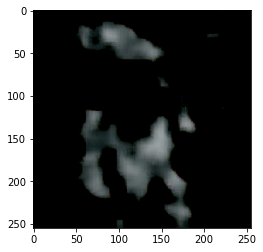

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


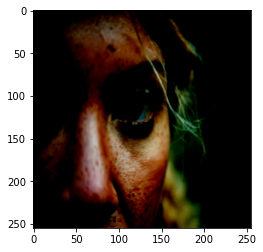

------------------------------------------------


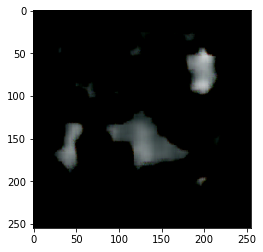

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


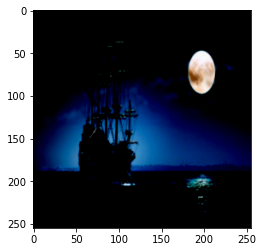

------------------------------------------------


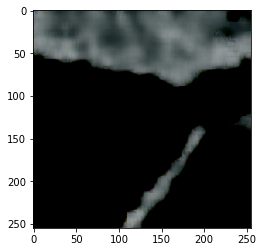

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


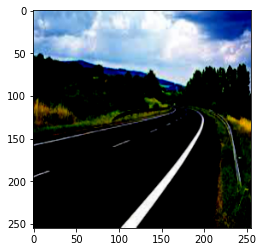

------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


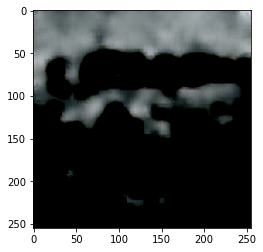

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


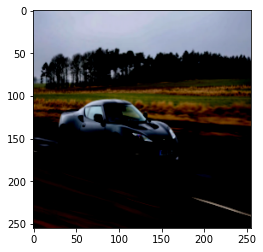

------------------------------------------------


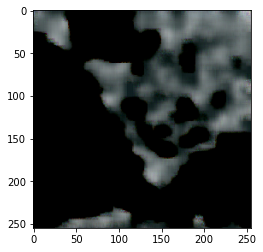

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


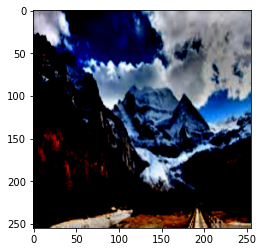

------------------------------------------------


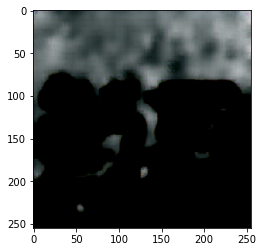

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


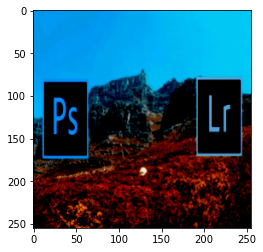

------------------------------------------------


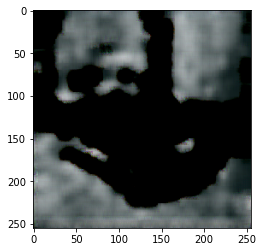

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


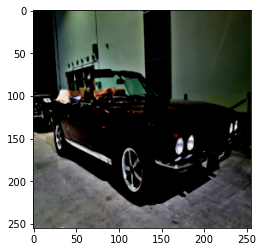

------------------------------------------------


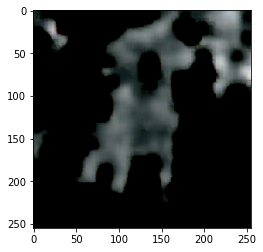

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


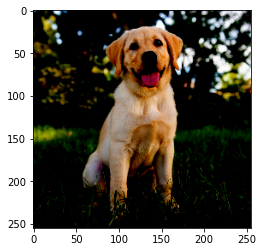

------------------------------------------------


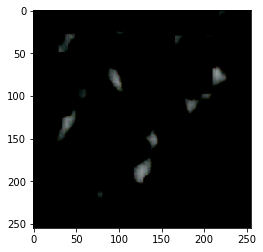

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


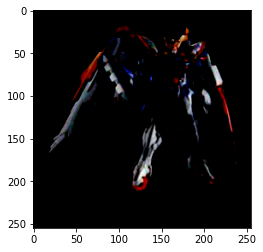

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------


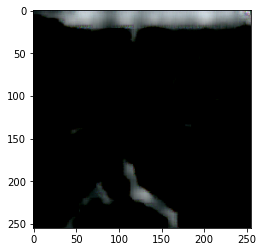

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


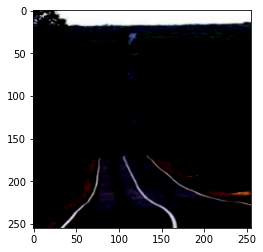

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------


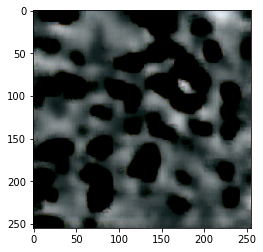

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


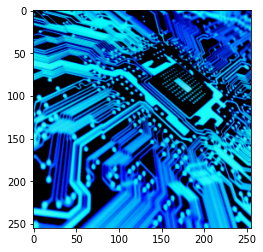

------------------------------------------------


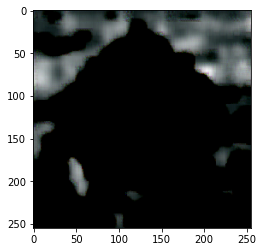

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


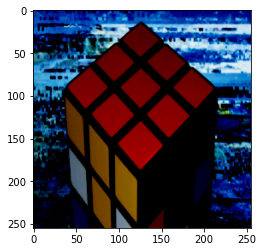

------------------------------------------------


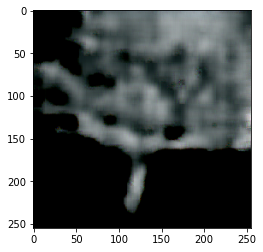

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


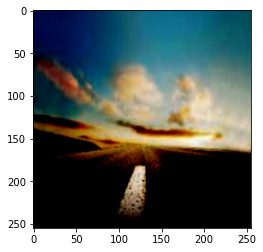

------------------------------------------------


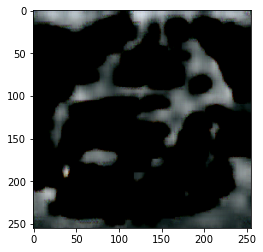

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


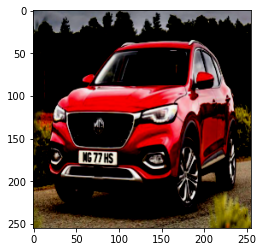

------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


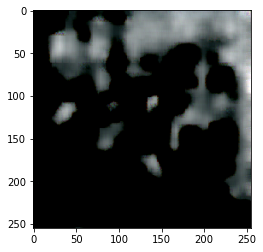

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


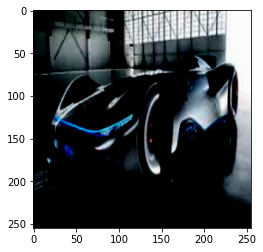

------------------------------------------------


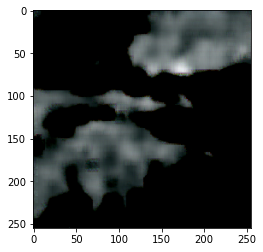

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


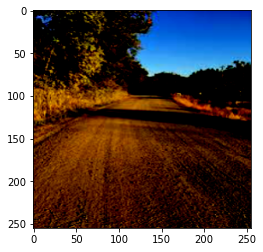

------------------------------------------------


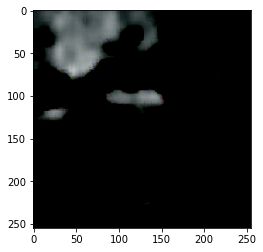

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


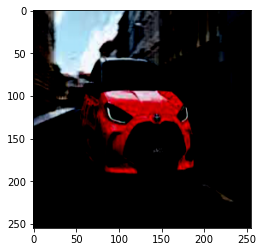

------------------------------------------------


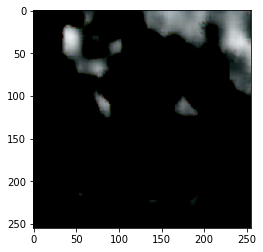

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


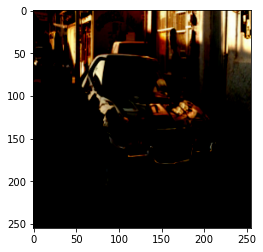

------------------------------------------------


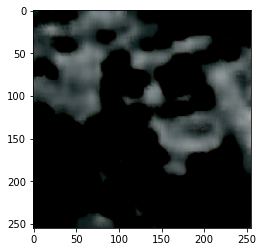

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


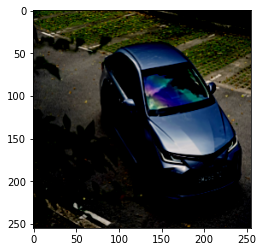

------------------------------------------------


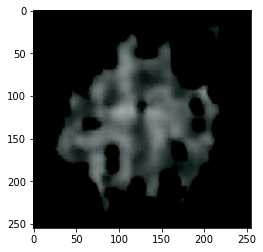

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


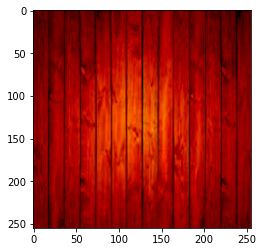

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------


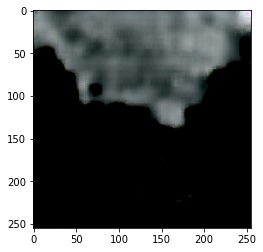

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


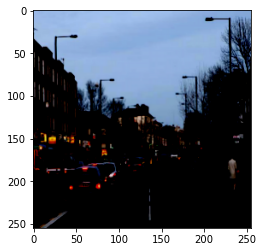

------------------------------------------------


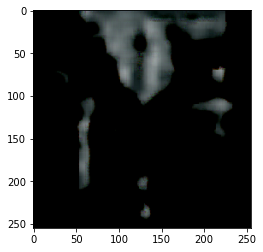

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


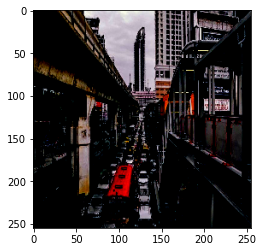

------------------------------------------------


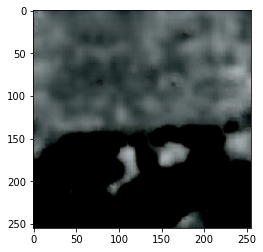

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


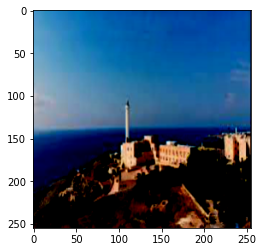

------------------------------------------------


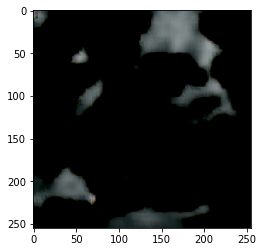

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


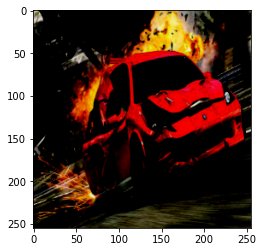

------------------------------------------------


In [20]:
autoencoder.eval()

tensor = torch.zeros(len(train_loader),latent_dims)

with torch.no_grad():
    image_low,image_high = iter(train_loader).next()    
       
    image_low = image_low.to(device)
    
    z,indices = autoencoder.encoder(image_low)
    z = z.to('cpu')

    mean = z.mean(dim=0)

    std = (z - mean).pow(2).mean(dim=0).sqrt()

    z1 = torch.randn(32, latent_dims)*std + mean
    z1 = z1.to(device)
    decodificado = autoencoder.decoder(z1,indices)

    decodificado = decodificado.to('cpu')
    print(decodificado.shape)
    for i in range(len(decodificado)): 
        show_img(decodificado[i])
        show_img(image_high[i])
        print("------------------------------------------------")

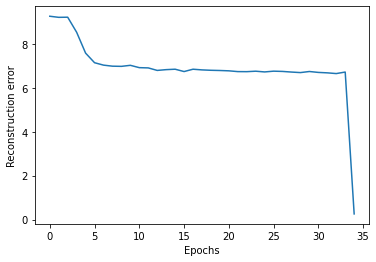

In [17]:
fig = plt.figure()
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


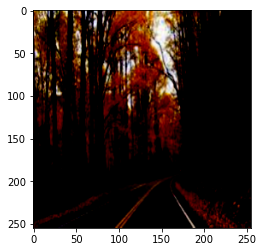

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


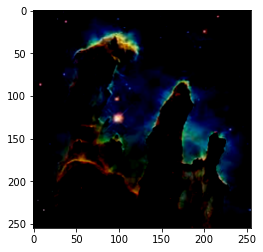

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


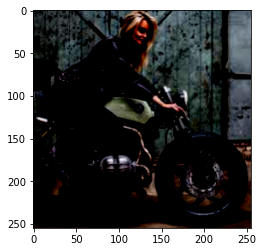

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


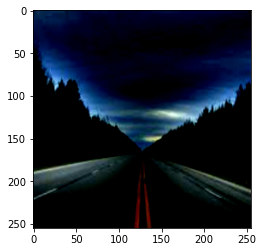

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


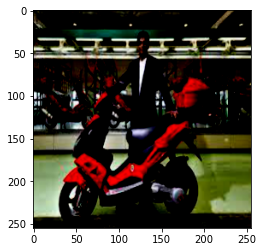

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


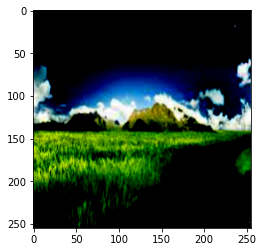

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


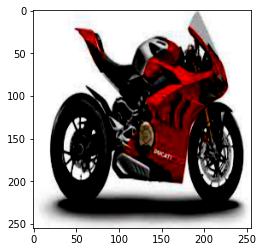

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


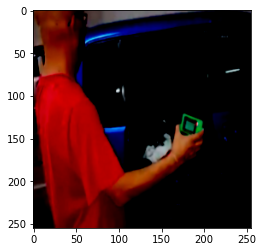

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


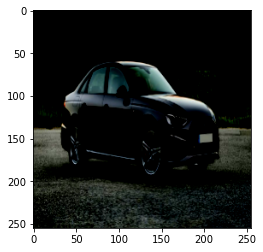

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


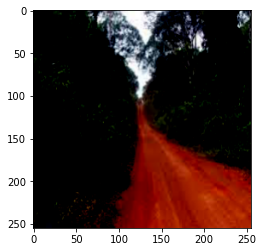

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


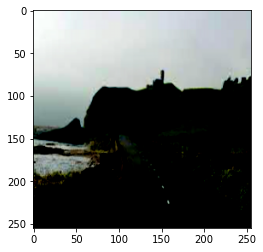

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


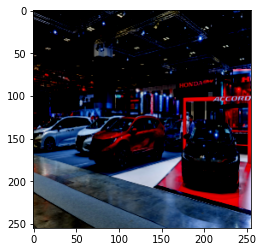

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


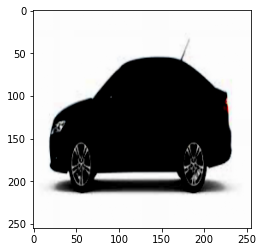

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


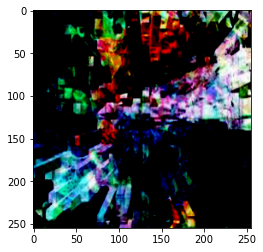

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


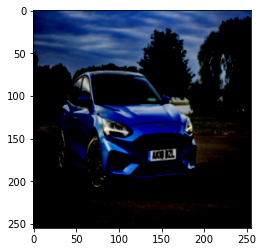

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


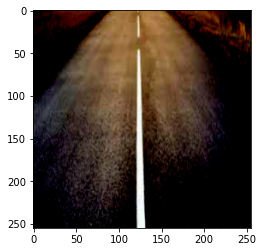

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


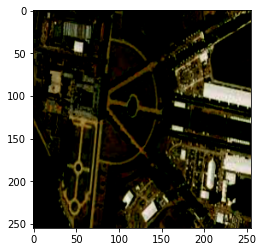

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


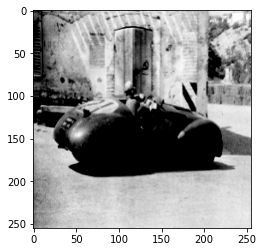

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


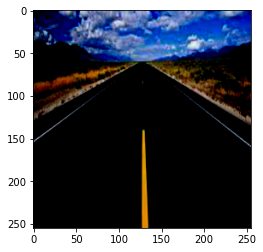

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


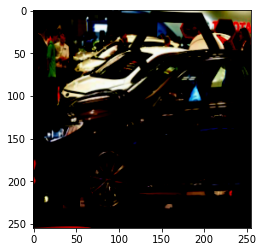

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


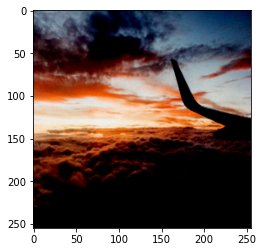

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


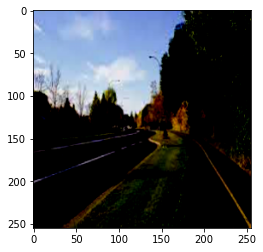

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


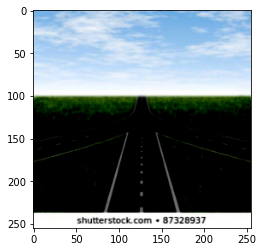

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


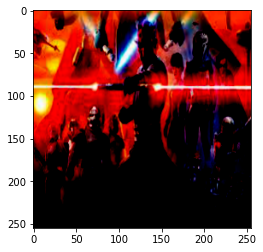

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


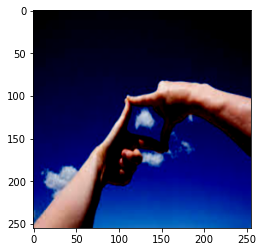

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


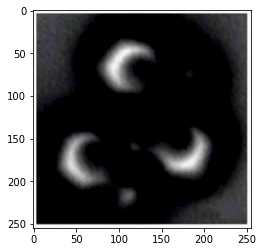

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


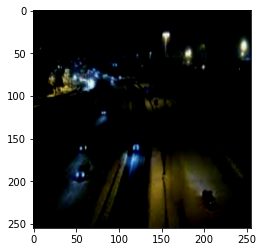

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


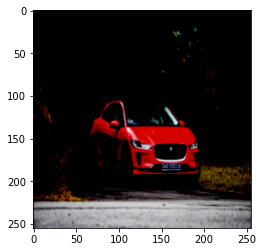

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


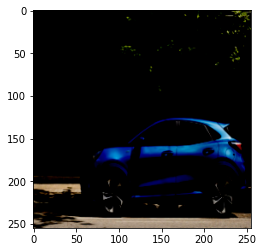

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


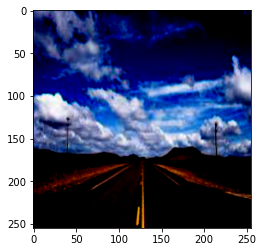

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


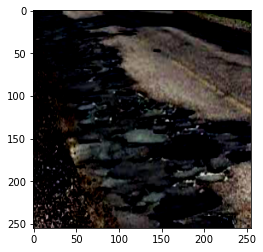

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


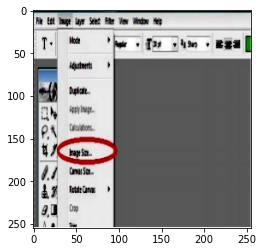

In [18]:
autoencoder.eval()
tensor = torch.zeros(len(test_loader),latent_dims)

with torch.no_grad():
    image,label = iter(test_loader).next()
    for i in label: show_img(i)
    